
# Loading Necessary Libraries 


In [1]:


import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import GridSearchCV
import numpy as np
import itertools
import warnings
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt






# Step 1: Datasets Loading and Cleaning and Pre-processing 



In [2]:


# Load the main dataset
file_path = 'new data.xlsx'
data = pd.read_excel(file_path)

# Load the weather dataset
weather_data_path = 'Weather data.xlsx'
weather_data = pd.read_excel(weather_data_path)




In [3]:


# Convert 'Local Time' to datetime format
data['Local Time'] = pd.to_datetime(data['Local Time'])
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Merge the datasets on the date and time
merged_data = pd.merge(data, weather_data, left_on='Local Time', right_on='Date', how='inner')
merged_data.drop(columns=['Date'], inplace=True)

# Display initial information about the merged dataset
print("Initial Merged Dataset Info:")
merged_data.info()





Initial Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7802 entries, 0 to 7801
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Local Time          7802 non-null   datetime64[ns]
 1   Unnamed: 1          0 non-null      float64       
 2   Unnamed: 2          0 non-null      float64       
 3   Unnamed: 3          0 non-null      float64       
 4   Unnamed: 4          0 non-null      float64       
 5   Unnamed: 5          0 non-null      float64       
 6   Unnamed: 6          0 non-null      float64       
 7   Unnamed: 7          0 non-null      float64       
 8   Unnamed: 8          0 non-null      float64       
 9   kWh UF Heat         7802 non-null   float64       
 10  kWh Water           7802 non-null   float64       
 11  kWh Sauna           7802 non-null   float64       
 12  kWh General         7802 non-null   float64       
 13  Season             

In [4]:


# Remove empty columns
merged_data = merged_data.drop(columns=[col for col in merged_data.columns if "Unnamed" in col])

# Check for missing values
print("\nMissing Values in Each Column:")
print(merged_data.isnull().sum())





Missing Values in Each Column:
Local Time            0
kWh UF Heat           0
kWh Water             0
kWh Sauna             0
kWh General           0
Season                0
Precipitation (mm)    0
Temperature (C)       0
Humidity (%)          0
wind speed (knot)     0
Wind speed m/s        0
dtype: int64



# Since there are no missing values in the dataset, proceed to the next steps.



In [5]:


# Set 'Local Time' as the index for time-series analysis
merged_data.set_index('Local Time', inplace=True)

# Additional preprocessing: Create new time-based features
merged_data['Year'] = merged_data.index.year
merged_data['Month'] = merged_data.index.month
merged_data['Day'] = merged_data.index.day
merged_data['Hour'] = merged_data.index.hour
merged_data['Day of Week'] = merged_data.index.dayofweek

# Verify the preprocessing steps
print("\nPreprocessed Merged Dataset Info:")
merged_data.info()




Preprocessed Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7802 entries, 2019-06-01 00:00:00 to 2020-06-01 00:00:00
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   kWh UF Heat         7802 non-null   float64
 1   kWh Water           7802 non-null   float64
 2   kWh Sauna           7802 non-null   float64
 3   kWh General         7802 non-null   float64
 4   Season              7802 non-null   object 
 5   Precipitation (mm)  7802 non-null   float64
 6   Temperature (C)     7802 non-null   float64
 7   Humidity (%)        7802 non-null   int64  
 8   wind speed (knot)   7802 non-null   int64  
 9   Wind speed m/s      7802 non-null   float64
 10  Year                7802 non-null   int32  
 11  Month               7802 non-null   int32  
 12  Day                 7802 non-null   int32  
 13  Hour                7802 non-null   int32  
 14  Day of Week         7802 non-null

In [6]:


# Display the first few rows of the preprocessed dataset
print("\nFirst Few Rows of Preprocessed Merged Dataset:")
print(merged_data.head())





First Few Rows of Preprocessed Merged Dataset:
                     kWh UF Heat  kWh Water  kWh Sauna  kWh General  Season  \
Local Time                                                                    
2019-06-01 00:00:00     0.034940   0.130746        0.0     0.061080  Summer   
2019-06-01 01:00:00     0.040758   0.140866        0.0     0.069304  Summer   
2019-06-01 02:00:00     0.040567   0.000000        0.0     0.072763  Summer   
2019-06-01 03:00:00     0.046072   0.000000        0.0     0.081609  Summer   
2019-06-01 04:00:00     0.046077   0.000000        0.0     0.068129  Summer   

                     Precipitation (mm)  Temperature (C)  Humidity (%)  \
Local Time                                                               
2019-06-01 00:00:00                 0.0             10.7            90   
2019-06-01 01:00:00                 0.0              9.7            89   
2019-06-01 02:00:00                 0.0              9.5            91   
2019-06-01 03:00:00         

In [7]:


# Save the cleaned merged dataset for future steps
cleaned_merged_file_path = 'cleaned_merged_data.csv'
merged_data.to_csv(cleaned_merged_file_path, index=True)

print(f"\nCleaned merged dataset saved to {cleaned_merged_file_path}")





Cleaned merged dataset saved to cleaned_merged_data.csv




# Step 2: Feature Engineering



In [8]:


# Load the cleaned dataset
file_path = 'cleaned_data.csv'
data = pd.read_csv(file_path, parse_dates=['Local Time'], index_col='Local Time')

# Verify and remove duplicate indices
data = data[~data.index.duplicated(keep='first')]

# Initialize a dictionary to store new features
lag_rolling_features = {}

# Create lag features for all target variables
for col in ['kWh General', 'kWh UF Heat', 'kWh Water', 'kWh Sauna']:
    for lag in range(1, 25):  # Creating lag features for the past 24 hours
        lag_rolling_features[f'{col}_Lag_{lag}'] = data[col].shift(lag)



In [9]:


# Create rolling statistics features for all target variables
for col in ['kWh General', 'kWh UF Heat', 'kWh Water', 'kWh Sauna']:
    lag_rolling_features[f'{col}_Rolling_Mean_3'] = data[col].rolling(window=3).mean()
    lag_rolling_features[f'{col}_Rolling_Mean_6'] = data[col].rolling(window=6).mean()
    lag_rolling_features[f'{col}_Rolling_Mean_12'] = data[col].rolling(window=12).mean()
    lag_rolling_features[f'{col}_Rolling_Mean_24'] = data[col].rolling(window=24).mean()
    
    lag_rolling_features[f'{col}_Rolling_Std_3'] = data[col].rolling(window=3).std()
    lag_rolling_features[f'{col}_Rolling_Std_6'] = data[col].rolling(window=6).std()
    lag_rolling_features[f'{col}_Rolling_Std_12'] = data[col].rolling(window=12).std()
    lag_rolling_features[f'{col}_Rolling_Std_24'] = data[col].rolling(window=24).std()

# Convert the dictionary to a DataFrame
lag_rolling_features_df = pd.DataFrame(lag_rolling_features)

# Drop rows with NaN values created by lagging and rolling statistics
lag_rolling_features_df = lag_rolling_features_df.dropna()

# Concatenate the new features with the original data
data = pd.concat([data, lag_rolling_features_df], axis=1)

# Drop rows with NaN values created by lagging and rolling statistics
data = data.dropna()



In [10]:


# Verify the feature engineering steps
print("\nFeature Engineered Dataset Info:")
data.info()

# Display the first few rows of the feature-engineered dataset
print("\nFirst Few Rows of Feature-Engineered Dataset:")
print(data.head())

# Save the feature-engineered dataset for future steps
feature_engineered_file_path = 'feature_engineered_data.csv'
data.to_csv(feature_engineered_file_path, index=True)

print(f"\nFeature-engineered dataset saved to {feature_engineered_file_path}")





Feature Engineered Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31180 entries, 2019-06-01 06:00:00 to 2020-06-01 00:00:00
Columns: 138 entries, kWh UF Heat to kWh Sauna_Rolling_Std_24
dtypes: float64(132), int64(5), object(1)
memory usage: 33.1+ MB

First Few Rows of Feature-Engineered Dataset:
                     kWh UF Heat  kWh Water  kWh Sauna  kWh General  Season  \
Local Time                                                                    
2019-06-01 06:00:00     0.045891   0.085172        0.0     0.072605  Summer   
2019-06-01 06:15:00     0.045919   0.000000        0.0     0.061649  Summer   
2019-06-01 06:30:00     0.045818   0.000000        0.0     0.064605  Summer   
2019-06-01 06:45:00     0.045724   0.000000        0.0     0.056171  Summer   
2019-06-01 07:00:00     0.045673   0.000000        0.0     0.075217  Summer   

                     Year  Month  Day  Hour  Day of Week  ...  \
Local Time                                                ... 



# Step 3: Model Development




# Develop LSTM Model for multiple targets




In [11]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input



In [12]:


# Load the feature-engineered dataset
file_path = 'feature_engineered_data.csv'
data = pd.read_csv(file_path, parse_dates=['Local Time'], index_col='Local Time')




In [13]:


# Function to develop and evaluate the LSTM model for a given target variable
def develop_and_evaluate_model(target_variable):
    print(f"\nDeveloping model for: {target_variable}")

    # Define the target variable and features
    X = data.drop(columns=[target_variable])
    y = data[target_variable]

    print("Target and features defined.")
    
    # One-Hot Encode the 'Season' column
    X = pd.get_dummies(X, columns=['Season'], drop_first=True)
    print("One-Hot Encoding done.")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

    # Normalize the features for LSTM
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the features for LSTM input
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    print(f"Shapes after scaling - X_train_scaled: {X_train_scaled.shape}, X_test_scaled: {X_test_scaled.shape}")

    # Initialize and train the LSTM model
    lstm_model = Sequential()
    lstm_model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    lstm_model.add(LSTM(50, activation='relu'))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

    # Make predictions
    y_pred_lstm = lstm_model.predict(X_test_scaled)

    # Evaluate the model
    mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
    rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
    r2_lstm = r2_score(y_test, y_pred_lstm)

    print(f"LSTM Model Evaluation Metrics for {target_variable}:")
    print(f"Mean Absolute Error (MAE): {mae_lstm}")
    print(f"Root Mean Square Error (RMSE): {rmse_lstm}")
    print(f"R-squared (R²): {r2_lstm}")

    # Save the trained model in the native Keras format
    lstm_model_file_path = f'trained_lstm_model_{target_variable}.keras'
    lstm_model.save(lstm_model_file_path)
    print(f"\nTrained LSTM model for {target_variable} saved to {lstm_model_file_path}")

# List of target variables to develop and evaluate models for
target_variables = ['kWh General', 'kWh UF Heat', 'kWh Water', 'kWh Sauna']

# Develop and evaluate models for each target variable
for target in target_variables:
    develop_and_evaluate_model(target)





Developing model for: kWh General
Target and features defined.
One-Hot Encoding done.
Shapes - X_train: (24944, 139), X_test: (6236, 139), y_train: (24944,), y_test: (6236,)
Shapes after scaling - X_train_scaled: (24944, 1, 139), X_test_scaled: (6236, 1, 139)
Epoch 1/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0119
Epoch 2/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041
Epoch 3/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011
Epoch 4/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4846e-04
Epoch 5/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5118e-04
Epoch 6/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9594e-04
Epoch 7/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2208e-04
Epoch 8/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8649e-04
Epoch 9/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8563e-04
Epoch 10/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6254e-04
Epoch 11/50
780/780 ━━━━━━━━━━━━━━━━━━━━




# Develop Random Forest Model for multiple targets





In [14]:

from sklearn.ensemble import RandomForestRegressor
import joblib



In [15]:


# Function to develop and evaluate the Random Forest model for a given target variable
def develop_and_evaluate_rf_model(target_variable):
    print(f"\nDeveloping Random Forest model for: {target_variable}")

    # Define the target variable and features
    X = data.drop(columns=[target_variable])
    y = data[target_variable]

    # One-Hot Encode the 'Season' column
    X = pd.get_dummies(X, columns=['Season'], drop_first=True)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Initialize and train the Random Forest Regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred_rf = rf_model.predict(X_test)

    # Evaluate the model
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    r2_rf = r2_score(y_test, y_pred_rf)

    print(f"Random Forest Model Evaluation Metrics for {target_variable}:")
    print(f"Mean Absolute Error (MAE): {mae_rf}")
    print(f"Root Mean Square Error (RMSE): {rmse_rf}")
    print(f"R-squared (R²): {r2_rf}")

    # Save the trained model
    rf_model_file_path = f'trained_rf_model_{target_variable}.pkl'
    joblib.dump(rf_model, rf_model_file_path)
    print(f"\nTrained Random Forest model for {target_variable} saved to {rf_model_file_path}")

# Develop and evaluate Random Forest models for each target variable
for target in target_variables:
    develop_and_evaluate_rf_model(target)





Developing Random Forest model for: kWh General
Random Forest Model Evaluation Metrics for kWh General:
Mean Absolute Error (MAE): 0.006711719539101913
Root Mean Square Error (RMSE): 0.018625991126220893
R-squared (R²): 0.9796400030084874

Trained Random Forest model for kWh General saved to trained_rf_model_kWh General.pkl

Developing Random Forest model for: kWh UF Heat
Random Forest Model Evaluation Metrics for kWh UF Heat:
Mean Absolute Error (MAE): 0.002054265405027855
Root Mean Square Error (RMSE): 0.008787944754635959
R-squared (R²): 0.9987152708922722

Trained Random Forest model for kWh UF Heat saved to trained_rf_model_kWh UF Heat.pkl

Developing Random Forest model for: kWh Water
Random Forest Model Evaluation Metrics for kWh Water:
Mean Absolute Error (MAE): 0.0004979511399772728
Root Mean Square Error (RMSE): 0.0031320872061824418
R-squared (R²): 0.9965039498912662

Trained Random Forest model for kWh Water saved to trained_rf_model_kWh Water.pkl

Developing Random Forest






# Develop ARIMA Model for multiple targets







In [87]:


from statsmodels.tsa.arima.model import ARIMA




In [88]:


# Function to develop and evaluate the ARIMA model for a given target variable
def develop_and_evaluate_arima_model(target_variable):
    print(f"\nDeveloping ARIMA model for: {target_variable}")

    # Define the target variable
    y = data[target_variable]

    # Split the data into training and testing sets
    train_size = int(len(y) * 0.8)
    y_train, y_test = y[:train_size], y[train_size:]

    # Fit ARIMA model
    arima_model = ARIMA(y_train, order=(5, 1, 0))  # You may need to experiment with the order
    arima_model_fit = arima_model.fit()

    # Make predictions
    y_pred_arima = arima_model_fit.forecast(steps=len(y_test))

    # Evaluate the model
    mae_arima = mean_absolute_error(y_test, y_pred_arima)
    rmse_arima = np.sqrt(mean_squared_error(y_test, y_pred_arima))
    r2_arima = r2_score(y_test, y_pred_arima)

    print(f"ARIMA Model Evaluation Metrics for {target_variable}:")
    print(f"Mean Absolute Error (MAE): {mae_arima}")
    print(f"Root Mean Square Error (RMSE): {rmse_arima}")
    print(f"R-squared (R²): {r2_arima}")

    # Save the trained model
    arima_model_file_path = f'trained_arima_model_{target_variable}.pkl'
    arima_model_fit.save(arima_model_file_path)
    print(f"\nTrained ARIMA model for {target_variable} saved to {arima_model_file_path}")

# Develop and evaluate ARIMA models for each target variable
for target in target_variables:
    develop_and_evaluate_arima_model(target)




Developing ARIMA model for: kWh General


C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Python312\Lib\site-packages\statsmodels\tsa\base\

ARIMA Model Evaluation Metrics for kWh General:
Mean Absolute Error (MAE): 0.08205508214118439
Root Mean Square Error (RMSE): 0.1310372955203127
R-squared (R²): -0.007694221755502051

Trained ARIMA model for kWh General saved to trained_arima_model_kWh General.pkl

Developing ARIMA model for: kWh UF Heat


C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Model Evaluation Metrics for kWh UF Heat:
Mean Absolute Error (MAE): 0.185317075665268
Root Mean Square Error (RMSE): 0.3073294626877712
R-squared (R²): -0.5712501100691227

Trained ARIMA model for kWh UF Heat saved to trained_arima_model_kWh UF Heat.pkl

Developing ARIMA model for: kWh Water


C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Python312\Lib\site-packages\statsmodels\tsa\base\

ARIMA Model Evaluation Metrics for kWh Water:
Mean Absolute Error (MAE): 0.04015679110281265
Root Mean Square Error (RMSE): 0.053727105758690434
R-squared (R²): -0.028719209927127176

Trained ARIMA model for kWh Water saved to trained_arima_model_kWh Water.pkl

Developing ARIMA model for: kWh Sauna


C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Python312\Lib\site-packages\statsmodels\tsa\base\

ARIMA Model Evaluation Metrics for kWh Sauna:
Mean Absolute Error (MAE): 0.009837246508012114
Root Mean Square Error (RMSE): 0.11344825032034182
R-squared (R²): -0.006863223470325419

Trained ARIMA model for kWh Sauna saved to trained_arima_model_kWh Sauna.pkl




# Comparison Charts



In [16]:


import matplotlib.pyplot as plt
import numpy as np



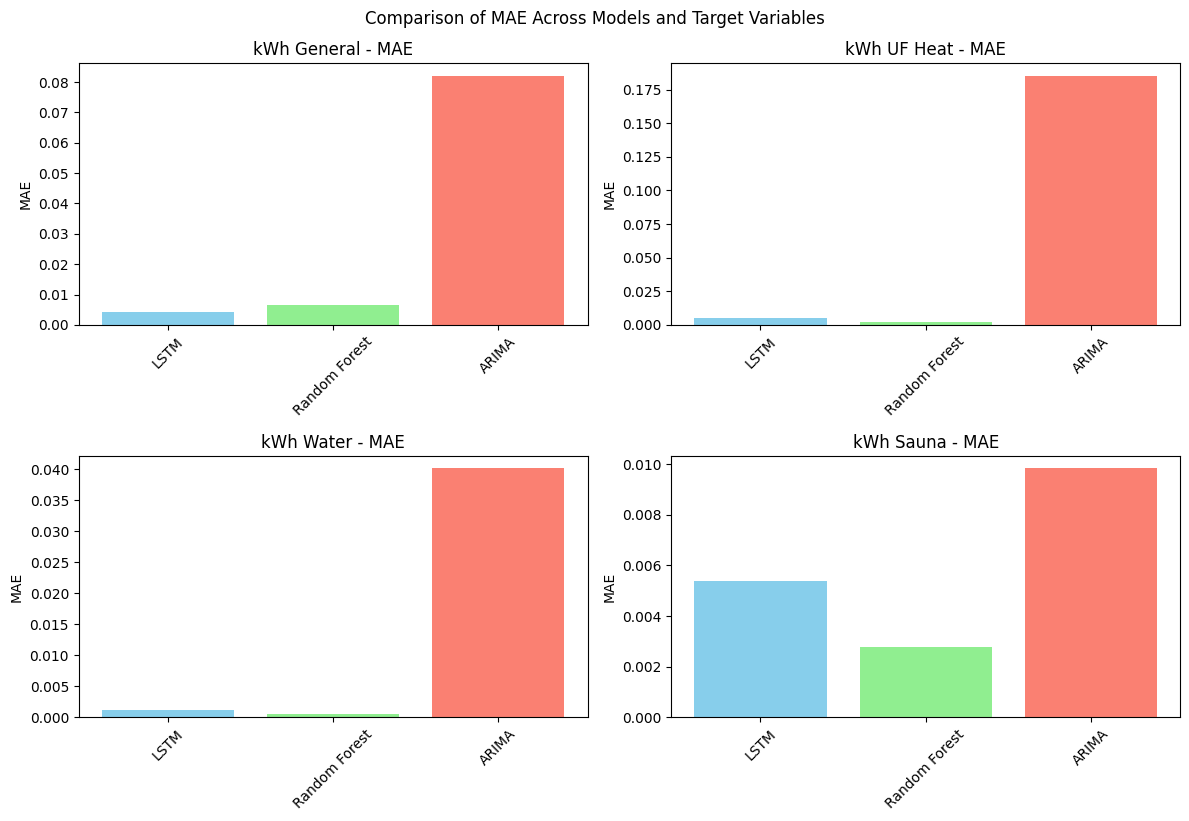

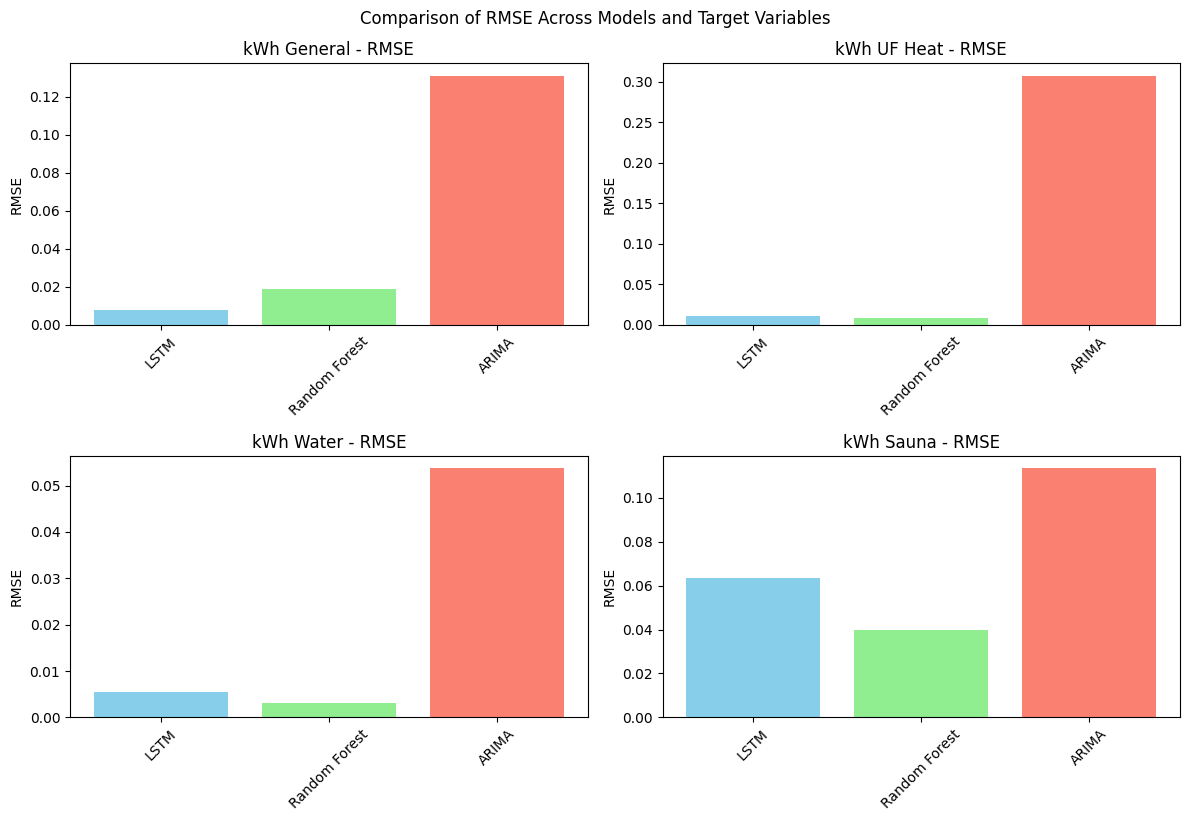

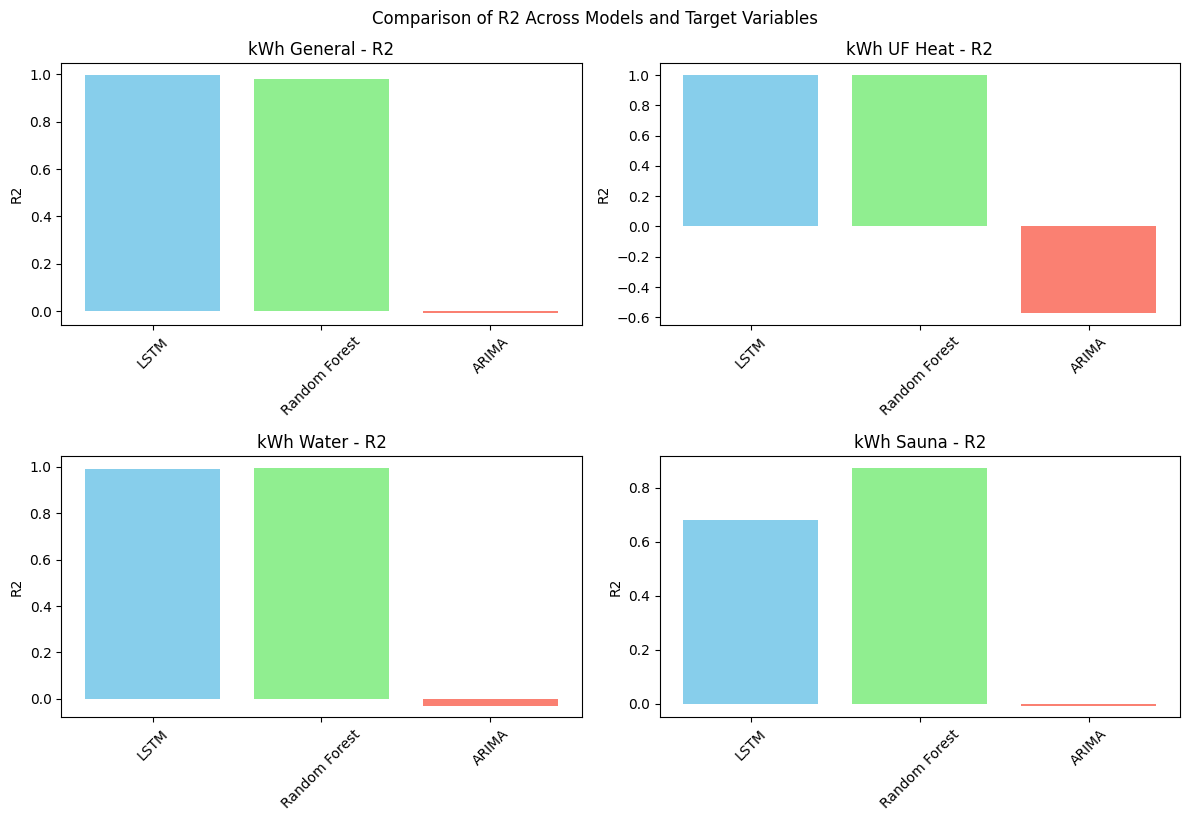

In [17]:


# Summary of results
results = {
    'kWh General': {
        'LSTM': {'MAE': 0.004259836676604031, 'RMSE': 0.007624924787275149, 'R2': 0.9965879918934563},
        'Random Forest': {'MAE': 0.006711719539101913, 'RMSE': 0.018625991126220893, 'R2': 0.9796400030084874},
        'ARIMA': {'MAE': 0.08205508214118439, 'RMSE': 0.1310372955203127, 'R2': -0.007694221755502051}
    },
    'kWh UF Heat': {
        'LSTM': {'MAE': 0.004772890436462429, 'RMSE': 0.01155958792733059, 'R2': 0.9977770912604857},
        'Random Forest': {'MAE': 0.002054265405027855, 'RMSE': 0.008787944754635959, 'R2': 0.9987152708922722},
        'ARIMA': {'MAE': 0.185317075665268, 'RMSE': 0.3073294626877712, 'R2': -0.5712501100691227}
    },
    'kWh Water': {
        'LSTM': {'MAE': 0.0011437237725803486, 'RMSE': 0.005465361885552454, 'R2': 0.9893549475603587},
        'Random Forest': {'MAE': 0.0004979511399772728, 'RMSE': 0.0031320872061824418, 'R2': 0.9965039498912662},
        'ARIMA': {'MAE': 0.04015679110281265, 'RMSE': 0.053727105758690434, 'R2': -0.028719209927127176}
    },
    'kWh Sauna': {
        'LSTM': {'MAE': 0.005394911039318928, 'RMSE': 0.06366563621186525, 'R2': 0.6829081788165443},
        'Random Forest': {'MAE': 0.00276493858999797, 'RMSE': 0.03994028181176905, 'R2': 0.8752050178295481},
        'ARIMA': {'MAE': 0.009837246508012114, 'RMSE': 0.11344825032034182, 'R2': -0.006863223470325419}
    }
}

# Function to create bar charts for comparison
def create_comparison_charts(results):
    metrics = ['MAE', 'RMSE', 'R2']
    models = ['LSTM', 'Random Forest', 'ARIMA']
    target_variables = list(results.keys())

    for metric in metrics:
        plt.figure(figsize=(12, 8))
        for i, target in enumerate(target_variables):
            plt.subplot(2, 2, i+1)
            values = [results[target][model][metric] for model in models]
            plt.bar(models, values, color=['skyblue', 'lightgreen', 'salmon'])
            plt.title(f'{target} - {metric}')
            plt.ylabel(metric)
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.suptitle(f'Comparison of {metric} Across Models and Target Variables', y=1.02)
        plt.show()

create_comparison_charts(results)





# Hyper Parameter Tuning for LSTM Model



In [5]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV



In [ ]:


# Load the feature-engineered dataset
file_path = 'feature_engineered_data.csv'
data = pd.read_csv(file_path, parse_dates=['Local Time'], index_col='Local Time')

# Function to create LSTM model
def create_lstm_model(input_shape, units=50, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Adjust input shape dynamically
    model.add(LSTM(units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Define the parameter grid for GridSearchCV
param_grid = {
    'model__units': [50, 100, 200],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]  # Reduced epochs for quicker testing
}

# Loop to perform hyperparameter tuning for each target variable
for target in ['kWh General', 'kWh UF Heat', 'kWh Water', 'kWh Sauna']:
    print(f"\nHyperparameter tuning for LSTM model - Target: {target}")
    
    # Define the target variable and features
    X = data.drop(columns=[target])
    y = data[target]

    # One-Hot Encode the 'Season' column
    X = pd.get_dummies(X, columns=['Season'], drop_first=True)

    print(f"Shape of X after one-hot encoding: {X.shape}")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

    # Normalize the features for LSTM
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the features for LSTM input
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    input_shape = (1, X_train_scaled.shape[2])
    print(f"Shapes after scaling and reshaping - X_train_scaled: {X_train_scaled.shape}, X_test_scaled: {X_test_scaled.shape}")
    print(f"Input shape for the model: {input_shape}")

    # Wrap the Keras model with KerasRegressor
    model = KerasRegressor(model=create_lstm_model, model__input_shape=input_shape, verbose=0)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1, error_score='raise')
    
    try:
        grid_search.fit(X_train_scaled, y_train)
        
        # Get the best model
        best_lstm_model = grid_search.best_estimator_

        # Make predictions
        y_pred_lstm_tuned = best_lstm_model.predict(X_test_scaled)

        # Evaluate the tuned model
        mae_lstm_tuned = mean_absolute_error(y_test, y_pred_lstm_tuned)
        rmse_lstm_tuned = np.sqrt(mean_squared_error(y_test, y_pred_lstm_tuned))
        r2_lstm_tuned = r2_score(y_test, y_pred_lstm_tuned)

        print(f"Best Parameters for LSTM model - Target: {target}: {grid_search.best_params_}")
        print(f"Tuned LSTM Model Evaluation Metrics for {target}:")
        print(f"Mean Absolute Error (MAE): {mae_lstm_tuned}")
        print(f"Root Mean Square Error (RMSE): {rmse_lstm_tuned}")
        print(f"R-squared (R²): {r2_lstm_tuned}")

        # Save the tuned model
        tuned_lstm_model_file_path = f'tuned_lstm_model_{target}.keras'
        best_lstm_model.model_.save(tuned_lstm_model_file_path)
        print(f"\nTuned LSTM model for {target} saved to {tuned_lstm_model_file_path}")
        
    except Exception as e:
        print(f"An error occurred during hyperparameter tuning for {target}: {e}")







# Hyperparameter Tuning for Random Forest



In [56]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor



In [57]:


# Load the feature-engineered dataset
file_path = 'feature_engineered_data.csv'
data = pd.read_csv(file_path, parse_dates=['Local Time'], index_col='Local Time')

# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Loop to perform hyperparameter tuning for each target variable
for target in ['kWh General', 'kWh UF Heat', 'kWh Water', 'kWh Sauna']:
    print(f"\nHyperparameter tuning for Random Forest model - Target: {target}")
    
    # Define the target variable and features
    X = data.drop(columns=[target])
    y = data[target]

    # One-Hot Encode the 'Season' column
    X = pd.get_dummies(X, columns=['Season'], drop_first=True)

    print(f"Shape of X after one-hot encoding: {X.shape}")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

    # Normalize the features (optional for Random Forest but keeping consistent with LSTM preprocessing)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Shapes after scaling - X_train_scaled: {X_train_scaled.shape}, X_test_scaled: {X_test_scaled.shape}")

    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(random_state=42)

    # Perform GridSearchCV
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, verbose=1, n_jobs=-1, error_score='raise')
    
    try:
        grid_search_rf.fit(X_train_scaled, y_train)
        
        # Get the best model
        best_rf_model = grid_search_rf.best_estimator_

        # Make predictions
        y_pred_rf_tuned = best_rf_model.predict(X_test_scaled)

        # Evaluate the tuned model
        mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
        rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
        r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

        print(f"Best Parameters for Random Forest model - Target: {target}: {grid_search_rf.best_params_}")
        print(f"Tuned Random Forest Model Evaluation Metrics for {target}:")
        print(f"Mean Absolute Error (MAE): {mae_rf_tuned}")
        print(f"Root Mean Square Error (RMSE): {rmse_rf_tuned}")
        print(f"R-squared (R²): {r2_rf_tuned}")

        # Save the tuned model
        tuned_rf_model_file_path = f'tuned_rf_model_{target}.joblib'
        import joblib
        joblib.dump(best_rf_model, tuned_rf_model_file_path)
        print(f"\nTuned Random Forest model for {target} saved to {tuned_rf_model_file_path}")
        
    except Exception as e:
        print(f"An error occurred during hyperparameter tuning for {target}: {e}")





# Hyperparameter Tuning for ARIMA





In [9]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima.arima import AutoARIMA



In [60]:


# Load the feature-engineered dataset
file_path = 'feature_engineered_data.csv'
data = pd.read_csv(file_path, parse_dates=['Local Time'], index_col='Local Time')

# Define the parameter grid for GridSearchCV
param_grid_arima = {
    'p': [0, 1, 2, 3, 4, 5],
    'd': [0, 1, 2],
    'q': [0, 1, 2, 3, 4, 5],
    'seasonal': [True, False],
    'm': [12]  # Assuming monthly seasonality, adjust based on your data frequency
}

# Loop to perform hyperparameter tuning for each target variable
for target in ['kWh General', 'kWh UF Heat', 'kWh Water', 'kWh Sauna']:
    print(f"\nHyperparameter tuning for ARIMA model - Target: {target}")
    
    # Define the target variable and features
    y = data[target]

    # Split the data into training and testing sets
    y_train, y_test = train_test_split(y, test_size=0.2, random_state=42, shuffle=False)

    print(f"Shapes - y_train: {y_train.shape}, y_test: {y_test.shape}")

    # Perform GridSearchCV using AutoARIMA
    try:
        # Initialize the AutoARIMA model
        model = AutoARIMA(start_p=1, start_q=1,
                          max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        
        # Fit the model
        model.fit(y_train)
        
        # Make predictions
        y_pred_arima_tuned = model.predict(n_periods=len(y_test))

        # Evaluate the tuned model
        mae_arima_tuned = mean_absolute_error(y_test, y_pred_arima_tuned)
        rmse_arima_tuned = np.sqrt(mean_squared_error(y_test, y_pred_arima_tuned))
        r2_arima_tuned = r2_score(y_test, y_pred_arima_tuned)

        print(f"Tuned ARIMA Model Evaluation Metrics for {target}:")
        print(f"Mean Absolute Error (MAE): {mae_arima_tuned}")
        print(f"Root Mean Square Error (RMSE): {rmse_arima_tuned}")
        print(f"R-squared (R²): {r2_arima_tuned}")

        # Save the tuned model
        tuned_arima_model_file_path = f'tuned_arima_model_{target}.joblib'
        import joblib
        joblib.dump(model, tuned_arima_model_file_path)
        print(f"\nTuned ARIMA model for {target} saved to {tuned_arima_model_file_path}")
        
    except Exception as e:
        print(f"An error occurred during hyperparameter tuning for {target}: {e}")






# let's write a script that compares the performance of LSTM, Random Forest, and ARIMA models before and after hyperparameter tuning



In [ ]:


import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import load_model




In [ ]:


# Load the feature-engineered dataset
file_path = 'feature_engineered_data.csv'
data = pd.read_csv(file_path, parse_dates=['Local Time'], index_col='Local Time')

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2

# Function to plot model performance comparison
def plot_comparison(metrics, model_names, metric_name):
    plt.figure(figsize=(10, 6))
    x = np.arange(len(model_names))
    plt.bar(x, metrics)
    plt.xticks(x, model_names)
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name} Across Models')
    plt.show()

# List of target variables
target_variables = ['kWh General', 'kWh UF Heat', 'kWh Water', 'kWh Sauna']

# Initialize lists to store metrics for comparison
mae_scores = {'LSTM': [], 'RF': [], 'ARIMA': []}
rmse_scores = {'LSTM': [], 'RF': [], 'ARIMA': []}
r2_scores = {'LSTM': [], 'RF': [], 'ARIMA': []}

# Loop to compare models for each target variable
for target in target_variables:
    print(f"\nEvaluating models for target: {target}")
    
    # Define the target variable and features
    X = data.drop(columns=[target])
    y = data[target]
    
    # One-Hot Encode the 'Season' column
    X = pd.get_dummies(X, columns=['Season'], drop_first=True)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    # Normalize the features for LSTM
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Load and evaluate LSTM models
    lstm_model = load_model(f'trained_lstm_model_{target}.keras')
    tuned_lstm_model = load_model(f'tuned_lstm_model_{target}.keras')
    mae, rmse, r2 = evaluate_model(lstm_model, X_test_scaled, y_test, 'LSTM')
    mae_scores['LSTM'].append(mae)
    rmse_scores['LSTM'].append(rmse)
    r2_scores['LSTM'].append(r2)
    mae, rmse, r2 = evaluate_model(tuned_lstm_model, X_test_scaled, y_test, 'Tuned LSTM')
    mae_scores['LSTM'].append(mae)
    rmse_scores['LSTM'].append(rmse)
    r2_scores['LSTM'].append(r2)
    
    # Load and evaluate Random Forest models
    rf_model = joblib.load(f'trained_rf_model_{target}.joblib')
    tuned_rf_model = joblib.load(f'tuned_rf_model_{target}.joblib')
    mae, rmse, r2 = evaluate_model(rf_model, X_test, y_test, 'Random Forest')
    mae_scores['RF'].append(mae)
    rmse_scores['RF'].append(rmse)
    r2_scores['RF'].append(r2)
    mae, rmse, r2 = evaluate_model(tuned_rf_model, X_test, y_test, 'Tuned Random Forest')
    mae_scores['RF'].append(mae)
    rmse_scores['RF'].append(rmse)
    r2_scores['RF'].append(r2)

    # Load and evaluate ARIMA models
    arima_model = joblib.load(f'trained_arima_model_{target}.joblib')
    tuned_arima_model = joblib.load(f'tuned_arima_model_{target}.joblib')
    y_pred_arima = arima_model.predict(n_periods=len(y_test))
    y_pred_tuned_arima = tuned_arima_model.predict(n_periods=len(y_test))
    mae = mean_absolute_error(y_test, y_pred_arima)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_arima))
    r2 = r2_score(y_test, y_pred_arima)
    mae_scores['ARIMA'].append(mae)
    rmse_scores['ARIMA'].append(rmse)
    r2_scores['ARIMA'].append(r2)
    mae = mean_absolute_error(y_test, y_pred_tuned_arima)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned_arima))
    r2 = r2_score(y_test, y_pred_tuned_arima)
    mae_scores['ARIMA'].append(mae)
    rmse_scores['ARIMA'].append(rmse)
    r2_scores['ARIMA'].append(r2)

# Plot comparisons
model_names = ['LSTM', 'Tuned LSTM', 'Random Forest', 'Tuned RF', 'ARIMA', 'Tuned ARIMA']

# Plot MAE comparison
plot_comparison([np.mean(mae_scores['LSTM'][:2]), np.mean(mae_scores['LSTM'][2:]), 
                 np.mean(mae_scores['RF'][:2]), np.mean(mae_scores['RF'][2:]), 
                 np.mean(mae_scores['ARIMA'][:2]), np.mean(mae_scores['ARIMA'][2:])], 
                model_names, 'Mean Absolute Error (MAE)')

# Plot RMSE comparison
plot_comparison([np.mean(rmse_scores['LSTM'][:2]), np.mean(rmse_scores['LSTM'][2:]), 
                 np.mean(rmse_scores['RF'][:2]), np.mean(rmse_scores['RF'][2:]), 
                 np.mean(rmse_scores['ARIMA'][:2]), np.mean(rmse_scores['ARIMA'][2:])], 
                model_names, 'Root Mean Square Error (RMSE)')

# Plot R-squared comparison
plot_comparison([np.mean(r2_scores['LSTM'][:2]), np.mean(r2_scores['LSTM'][2:]), 
                 np.mean(r2_scores['RF'][:2]), np.mean(r2_scores['RF'][2:]), 
                 np.mean(r2_scores['ARIMA'][:2]), np.mean(r2_scores['ARIMA'][2:])], 
                model_names, 'R-squared (R²)')


